Successful designs: 147
Failed designs: 3

Example of failed cases (showing up to 5):
  Poles: [-5.  -2.  -3.5 -5. ] | Error: at least one of the requested pole is repeated more than rank(B) times
  Poles: [-5. -3. -5. -7.] | Error: at least one of the requested pole is repeated more than rank(B) times
  Poles: [-5. -4. -5. -8.] | Error: at least one of the requested pole is repeated more than rank(B) times

Best pole set found:
Continuous poles: [-4.15517241 -4.         -5.         -8.        ]
Discrete max eigenvalue magnitude: 0.8798533791442561
Approx settling time (s): 0.2499999999991393
K gain vector: [  5.14192458   2.39195645  30.70466238 -14.67038327]


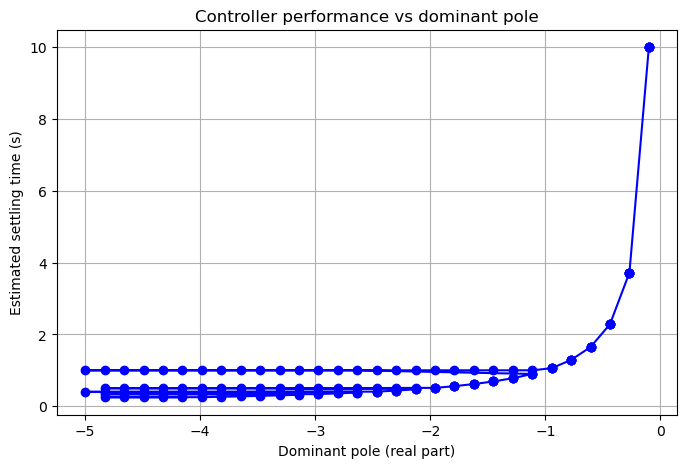

In [5]:
import numpy as np
from scipy import signal, linalg
import matplotlib.pyplot as plt

# --- Vehicle parameters ---
lr = 1.39
lf = 1.55
Ca = 20000
Iz = 25854
m = 1888.6
v = 20
delT = 0.032

# --- Continuous-time lateral dynamics ---
A = np.array([
    [0, 1, 0, 0],
    [0, -4*Ca/(m*v), 4*Ca/m, -2*Ca*(lf - lr)/(m*v)],
    [0, 0, 0, 1],
    [0, -2*Ca*(lf - lr)/(Iz*v), 2*Ca*(lf - lr)/Iz, -2*Ca*(lf**2 + lr**2)/(Iz*v)]
])
B = np.array([[0], [2*Ca/m], [0], [2*Ca*lf/Iz]])

# Discretize for the controller design
C = np.eye(4)
D = np.zeros((4, 1))
Ad, Bd, _, _, _ = signal.cont2discrete((A, B, C, D), delT, method='zoh')

# --- Parameter sweep ---
dominant_poles = np.linspace(-0.1, -5.0, 30)  # wider range for dominant poles
secondary_sets = [
    [-2, -3.5, -5],
    [-2.5, -4, -6],
    [-3, -5, -7],
    [-1, -2, -4],    # milder secondary poles
    [-4, -5, -8]     # aggressive secondary poles
]

results = []
failed = []

for dom in dominant_poles:
    for sec in secondary_sets:
        poles = np.array([dom] + sec)
        desired_z = np.exp(poles * delT)
        try:
            res = signal.place_poles(Ad, Bd, desired_z, method='YT')
            K = res.gain_matrix.reshape(-1)

            eigs = np.linalg.eigvals(Ad - Bd @ K.reshape(1, -1))
            max_mag = np.max(np.abs(eigs))
            settling_time = -delT / np.log(max_mag) if max_mag < 1 else np.inf

            results.append({
                "poles": poles,
                "K": K,
                "max_mag": max_mag,
                "settling_time": settling_time
            })
        except Exception as e:
            failed.append((poles, str(e)))
            continue

# --- Print how many succeeded ---
print(f"Successful designs: {len(results)}")
print(f"Failed designs: {len(failed)}")

if len(failed) > 0:
    print("\nExample of failed cases (showing up to 5):")
    for i, (p, err) in enumerate(failed[:5]):
        print(f"  Poles: {p} | Error: {err}")

# --- Proceed only if we have valid results ---
if results:
    results = sorted(results, key=lambda r: r["settling_time"])
    best = results[0]
    print("\nBest pole set found:")
    print("Continuous poles:", best["poles"])
    print("Discrete max eigenvalue magnitude:", best["max_mag"])
    print("Approx settling time (s):", best["settling_time"])
    print("K gain vector:", best["K"])

    # --- Visualization ---
    plt.figure(figsize=(8,5))
    plt.plot([r["poles"][0] for r in results], [r["settling_time"] for r in results], 'bo-')
    plt.xlabel("Dominant pole (real part)")
    plt.ylabel("Estimated settling time (s)")
    plt.title("Controller performance vs dominant pole")
    plt.grid(True)
    plt.show()
else:
    print("\nNo valid pole placements found. Try adjusting ranges or checking A/B matrices.")
